<a href="https://colab.research.google.com/github/peruvianox/Vetta/blob/main/2Study_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [2]:
!pip install skl2onnx
!pip install onnxruntime

In [3]:
!pip install pingouin
!pip install tf2onnx

In [4]:
from google.colab import drive
drive.mount("/content/drive")
import os
import re
import pandas as pd
import datetime as dt
import numpy as np
import random
import json
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import signal
from scipy import interpolate
from google.colab import output
import sklearn
import tf2onnx
# print('sklearn version =', sklearn.__version__)
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
import time
from sklearn import svm
from sklearn.neural_network import MLPRegressor
import sqlite3
import pingouin as pg
import seaborn as sb
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import datasets, layers, models
DataFolder = '/content/drive/My Drive/Data'
os.chdir(DataFolder)

plt.rcParams.update({'font.size': 15})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Subject Data

In [5]:
# get study 1 data (2021)
Data = pd.read_csv('FullData.csv').reset_index(drop=True)
Cols = Data.columns
Cols2Del = []
for i, c in enumerate(Cols): # identify unnamed columns
  if 'Unnamed' in c:
    Cols2Del.append(c)
  if 'Shank' in c:
    Cols2Del.append(c)
  if 'Torso' in c:
    Cols2Del.append(c)
  if 'Foot' in c:
    Cols2Del.append(c)
S1Data = Data.drop(columns=Cols2Del) # get rid of unnamed column
S1Data.iloc[:,100:] = S1Data.iloc[:,100:] / 9.81
S1Meta = pd.read_csv('MetaData.csv').reset_index(drop=True)

In [6]:
# get study 2 data (2023)
Data = pd.read_csv('StepData.csv').reset_index(drop=True)
Cols = Data.columns
Cols2Del = []
for i, c in enumerate(Cols): # identify unnamed columns
  if 'Unnamed' in c:
    Cols2Del.append(c)
S2Data = Data.drop(columns=Cols2Del) # get rid of unnamed column
# S2Meta = pd.read_csv('StepMetaData.csv').reset_index(drop=True)
S2Meta = S2Data.iloc[:, :4]
S2Data = S2Data.iloc[:, 5:]
# print(S2Meta)

In [7]:
# combine study 1 and study 2 data
S1Data.columns = S2Data.columns
Steps = pd.concat([S1Data, S2Data], axis=0)
Steps.reset_index(inplace=True, drop=True)

# combine study 1 and study 2 meta data
S1Meta['Speed'] = np.repeat(['preferred'], len(S1Meta))
S1Meta['Load'] = S1Meta['Cond']
# correct load naming convention
S1Meta['Load'].replace('control','baseline', inplace=True)
S1Meta['Load'].replace('over','over5', inplace=True)
S1Meta['Load'].replace('under','under5', inplace=True)

Meta = pd.concat([S1Meta[['Subj','Load','Speed','Side']], S2Meta[['Subj','Load','Speed','Side']]], axis=0)
Meta.reset_index(inplace=True, drop=True)
# np.unique(Meta['Load'])

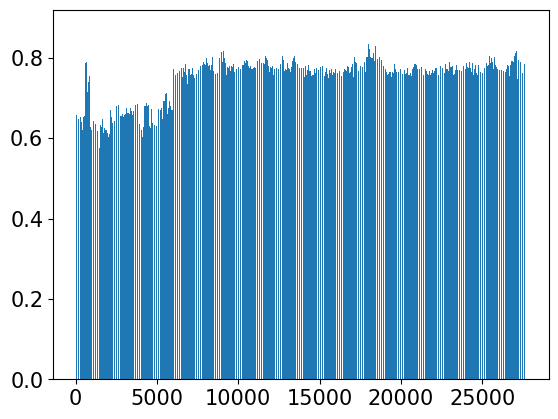

In [8]:
Means = Steps.to_numpy().mean(axis=1)
plt.bar(range(len(Means)), Means)
plt.savefig('Figures/StepMeans.png')

In [9]:
# Plot = 0
# if Plot == 1:
#   # plot acceleration data
#   Cols = Data.columns
#   from matplotlib import cm
#   from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#   C = cm.get_cmap('plasma', 20)

#   Foot = Data[[x for x in Data.columns if 'Foot' in x]].to_numpy().T
#   Shank = Data[[x for x in Data.columns if 'Shank' in x]].to_numpy().T
#   Waist = Data[[x for x in Data.columns if 'Waist' in x]].to_numpy().T
#   vGRF = Data[[x for x in Data.columns if 'GRF' in x]].to_numpy().T

#   plt.figure(figsize=(16,12))
#   ax1 = plt.subplot(221)
#   ax2 = plt.subplot(222)
#   ax3 = plt.subplot(223)
#   ax4 = plt.subplot(224)
#   A = 0.1

#   for r in range(len(Data)):
#     i = int(Meta.Subj[r][1:])
#     # plot all Acceleration signals
#     ax1.plot(vGRF[:,r],'-k', c=C.colors[i-1], alpha=A)
#     ax2.plot(Waist[:,r],'-k', c=C.colors[i-1], alpha=A)
#     ax3.plot(Shank[:,r],'-k', c=C.colors[i-1], alpha=A)
#     ax4.plot(Foot[:,r],'-k', c=C.colors[i-1], alpha=A)

#   # edit axes
#   ax1.set_title('A: Measured vGRF')
#   ax1.set_xlim([0, 100])
#   ax1.set_ylabel('vGRF (BW)')
#   ax2.set_title('B: Waist Input')
#   ax2.set_xlim([0, 100])
#   ax2.set_ylabel('Norm Acc (m/s^2)')
#   ax3.set_title('C: Shank Input')
#   ax3.set_xlim([0, 100])
#   ax3.set_ylabel('Norm Acc (m/s^2)')
#   ax3.set_xlabel('% Gait Cycle')
#   ax4.set_title('D: Foot Input')
#   ax4.set_xlim([0, 100])
#   ax4.set_ylabel('Norm Acc (m/s^2)')
#   ax4.set_xlabel('% Gait Cycle')

#   Subjs = np.unique(Meta.Subj)
#   ax4.text(112, 175, 'Subjects', c='k', ha='center', weight='bold')
#   for i in range(20):
#     ax4.text(112, 170 - 7*i, Subjs[i], c=C.colors[i], ha='center')

#   plt.savefig('/content/drive/My Drive/EII-PGB/Data/SyncedData/FigFolder/Inputs.png')
#   plt.savefig('/content/drive/My Drive/EII-PGB/Data/SyncedData/FigFolder/Inputs.pdf')

# Define functions for processing

In [10]:
# define functions for processing later on
def ccc(x,y):
    ''' Concordance Correlation Coefficient'''
    x = np.array(x)
    y = np.array(y)
    sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
    rhoc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
    return rhoc

def GetInds(Cols: list, Terms: list):
  # get indicies of terms in a list
  Inds = []
  for i, c in enumerate(Cols):
    for q in Terms:
      if re.match(q, c):
        Inds.append(i-1)

  return Inds

from matplotlib import cm
cmap = cm.rainbow(np.linspace(0, 1, 20))
plt.style = 'seaborn'

# Train & Test MLP

In [ ]:
# load prior results from json
fn = 'ModelResults.json'
with open(fn, 'r') as file:
  AggMLP = json.load(file)

Models = [[10], [100], [200], [500],
    [10, 10], [50, 50], [100, 100],
    [10, 50, 10], [100, 10, 100], [100, 50, 100],[100, 100, 100], [100, 200, 100], [100, 500, 100], [100, 1000, 100]]
MLPdata = {}

for Arch in Models:
  model = str(Arch)
  print(model)
  AggMLP[model] = {}

  # implement K-fold cross validation for splitting testing & training inputs
  X = Steps.iloc[:,100:]
  y = Steps.iloc[:,0:99]
  S = np.unique(Meta['Subj'])
  # split based on subject indexes
  kf = KFold(n_splits=10, shuffle=True)
  k = 0
  for TrainSubj, TestSubj in kf.split(S):
    print('Iteration: ' + str(k))
    TrainInds = [i for i, x in enumerate(Meta['Subj']) if x in S[TrainSubj]]
    TestInds = [i for i, x in enumerate(Meta['Subj']) if x in S[TestSubj]]

    # specify testing & training sets
    X_train = Steps.iloc[TrainInds, 100:].to_numpy()
    Y_train = Steps.iloc[TrainInds,:100].to_numpy()
    X_test = Steps.iloc[TestInds, 100:].to_numpy()
    Y_test = Steps.iloc[TestInds,:100].to_numpy()
    Meta_train = Meta.iloc[TrainInds]
    Meta_test = Meta.iloc[TestInds]

    # MLP
    MLPdata[model] = {}
    clf = MLPRegressor(random_state=1, max_iter=500, verbose=False, activation='logistic', hidden_layer_sizes=Arch)
    start = time.time()
    clf.fit(X_train,Y_train) # Fit model
    MLP_P = clf.predict(X_test) # predict
    finish = time.time()
    # MLP[model]['Model'] = clf

    # save outputs
    AggMLP[model][k] = {}
    AggMLP[model][k]['Training Time'] = finish-start
    AggMLP[model][k]['RMSE'] = np.sqrt(metrics.mean_absolute_error(Y_test, MLP_P))
    AggMLP[model][k]['MAE'] = metrics.mean_absolute_error(Y_test, MLP_P)
    AggMLP[model][k]['R^2'] = metrics.r2_score(Y_test, MLP_P)
    AggMLP[model][k]['CCC'] = round(ccc(Y_test, MLP_P), 4)
    # save data intermediates
    MLPdata[model]['Prediction'] = MLP_P
    MLPdata[model]['True'] = np.array(Y_test)
    MLPdata[model]['Test Metadata'] = Meta_test
    MLPdata[model]['Train Metadata'] = Meta_train
    MLPdata[model]['Test Input'] = np.array(X_test)
    MLPdataFN = 'ModelData/' + model + '_' + str(k) + '_arr.npz'
    Arrs = np.asarray([MLP_P, np.array(Y_test), Meta_test.to_numpy(), Meta_train.to_numpy(), np.array(X_test)], dtype='object')
    np.savez_compressed(MLPdataFN, Arrs)

    # print results
    print('MLP Model: ' + model)
    print('MAE = ' + str(AggMLP[model][k]['MAE']))
    print('')

    # Convert into ONNX format
    # from skl2onnx import convert_sklearn
    # from skl2onnx.common.data_types import FloatTensorType, DoubleTensorType
    # initial_type = [('double_input', DoubleTensorType([None, 100]))]
    # onx = convert_sklearn(clf, initial_types=initial_type)
    # with open("MLPmodel" + model + str(k) +  ".onnx", "wb") as f:
    #     f.write(onx.SerializeToString())

    k += 1

# save results to json
with open(fn, 'w') as file:
  json.dump(AggMLP, file, indent=2)

## Plot results

In [ ]:
# plot results across all architectures
plt.figure(figsize=(12, 12))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)
A1 = 0.5
A2 = 0.2

# load prior results from json
fn = 'ModelResults.json'
with open(fn, 'r') as file:
  AggMLP = json.load(file)

Models = [[10], [100], [200], [500],
    [10, 10], [50, 50], [100, 100],
    [100, 100, 100], [100, 10, 100], [100, 200, 100], [100, 50, 100], [100, 500, 100], [10, 50, 10], [100, 1000, 100]]

AvgError = {}
StdError = {}
LPAvgError = {}
LPStdError = {}
AvgTT = {}

MLPdata = {}
for Ind, Arch in enumerate(Models):
  model = str(Arch)
  MLPdata[model] = {}
  C = cm.get_cmap('viridis', len(AggMLP[model]))

  # initialize arrays
  AvgError[model] = []
  StdError[model] = []
  LPAvgError[model] = []
  LPStdError[model] = []
  AvgTT[model] = []

  # loop through KFold iterations of each model
  for i in range(len(AggMLP[model])):
    # load prior detailed ML outputs from numpy
    MLPdataFN = 'ModelData/' + model + '_' + str(i) + '_arr.npz'
    MLP = np.load(MLPdataFN, allow_pickle=True)
    MLPdata[model]['Prediction'] = MLP['arr_0'][0]
    MLPdata[model]['True'] = MLP['arr_0'][1]
    MLPdata[model]['Test Metadata'] = MLP['arr_0'][2]
    MLPdata[model]['Train Metadata'] = MLP['arr_0'][3]
    MLPdata[model]['Test Input'] = MLP['arr_0'][4]

    MLPdata[model]['TruePk'] = np.zeros((len(MLPdata[model]['True']),1))
    MLPdata[model]['PredPk'] = np.zeros((len(MLPdata[model]['Prediction']),1))
    MLPdata[model]['PkErr'] = np.zeros((len(MLPdata[model]['Prediction']),1))

    # plot stance MAE
    if Ind == 0:
      ax1.plot(Ind, AggMLP[model][str(i)]['MAE'], 'o', c=C.colors[i], label=i+1, alpha = A1)
    else:
      ax1.plot(Ind, AggMLP[model][str(i)]['MAE'], 'o', c=C.colors[i], alpha = A1)
    AvgError[model].append(np.mean(AggMLP[model][str(i)]['MAE']))
    StdError[model].append(np.std(AggMLP[model][str(i)]['MAE']))

    # plot loading peak error
    for r in range(len(MLPdata[model]['Prediction'])):
      MLPdata[model]['TruePk'][r] = np.max(MLPdata[model]['True'][r, 0:40])
      MLPdata[model]['PredPk'][r] = np.max(MLPdata[model]['Prediction'][r, 0:40])
      MLPdata[model]['PkErr'][r] = abs(MLPdata[model]['TruePk'][r] - MLPdata[model]['PredPk'][r])
      # plt.plot(Ind, MLPdata[model]['PkErr'][r], 'o', c=C.colors[i], alpha=A1)
    parts = ax2.violinplot(MLPdata[model]['PkErr'], positions=[Ind], widths=0.8,
                           showmeans=False, showmedians=False, showextrema=False)
    for pc in parts['bodies']:
      pc.set_facecolor(C.colors[i])
      pc.set_edgecolor(None)
      pc.set_alpha(A2)

    LPAvgError[model].append(np.mean(MLPdata[model]['PkErr']))
    LPStdError[model].append(np.std(MLPdata[model]['PkErr']))

     # plot training time
    ax3.plot(Ind, AggMLP[model][str(i)]['Training Time'], 'o', c=C.colors[i], alpha = A1)
    AvgTT[model].append(np.mean(AggMLP[model][str(i)]['Training Time']))

  # plot average stance MAE
  ax1.errorbar(Ind, np.mean(AvgError[model]), np.std(AvgError[model]), ms=10,
                  fmt='sk', ecolor='k', elinewidth=1, capsize=12)
  print(model, str(round(100 * np.mean(AvgError[model]), 3)))

  # plot average loading peak MAE
  ax2.errorbar(Ind, np.mean(LPAvgError[model]), np.mean(LPStdError[model]), ms=10,
                fmt='sk', ecolor='k', elinewidth=1, capsize=12)
  ax2.text(Ind, 0.23, str(round(np.mean(LPAvgError[model]),4)), ha='center', fontsize=12)

  # plot average Training Time
  ax3.errorbar(Ind, np.mean(AvgTT[model]), np.std(AvgTT[model]), ms=10,
                  fmt='sk', ecolor='k', elinewidth=1, capsize=12)


# organize subplots
ax1.legend(fontsize=10, title='K-Fold', ncols=2, title_fontsize=12)
ax1.set_xticks(range(len(Models)), [])
ax1.set_yticks([0.03, 0.04, 0.05, 0.06, 0.07])
# ax1.set_xticklabels([])
ax1.set_ylabel('Error (BW)')
ax1.set_title('A: Gait Cycle MAE')
ax1.set_xlim([-0.5, 13.5])

# ax2.set_xticks(range(len(Models)), Models, rotation=90)
ax2.set_xticks(range(len(Models)), [])
ax2.set_ylabel('Error (BW)')
ax2.set_title('B: Loading Peak MAE')
ax2.set_xlim([-0.5, 13.5])
ax2.set_ylim([0, 0.25])

ax3.set_xticks(range(len(Models)), Models, rotation=90)
ax3.set_ylabel('Time (s)')
ax3.set_title('C: Model Training Time')
ax3.set_xlim([-0.5, 13.5])
# ax3.set_ylim([0, 0.25])

plt.savefig('Figures/MLP_MAE.png')
# plt.savefig('Figures/MLP_MAE.pdf')

# Custom NN

In [13]:
# def log10(x):
#   numerator = tf.math.log(x)
#   denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
#   return numerator / denominator

# def LSD(y_true, y_pred):
#     linear_y_true = tf.math.exp(y_true)
#     linear_y_pred = tf.math.exp(y_pred)
#     ratio = tf.math.divide(linear_y_true, linear_y_pred)
#     return tf.math.sqrt(tf.math.reduce_sum((10*log10(ratio))**2)/(2*np.pi))

def learningRateScheduler(epoch, lr):
    """
    In paper learning rates were set to 1e−4 for first 10 epochs and 1e−5 for the rest.
    But we elected to change LR at 50 epochs as that is where our validation data
    set starts increasing in loss.
    """
    if epoch < 50:
        return 1e-4
    else:
        return 1e-5

def createModel():
    model = Sequential([
        Dense(100, activation='relu'), # Fully Connected 1
        Dense(100, activation='relu'), # Fully Connected 2
        Dense(100), # Output
    ])
    model.compile(optimizer="Adam", loss="mae", metrics=["mae"])
    return model

Iteration: 0
87/87 [==============================] - 1s 2ms/step


/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-09-08 16:13:27,600 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-09-08 16:13:27,860 - INFO - Signatures found in model: [serving_default].
2023-09-08 16:13:27,860 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-09-08 16:13:27,860 - INFO - Output names: ['dense_11']
2023-09-08 16:13:27,936 - INFO - Using tensorflow=2.12.0, onnx=1.14.1, tf2onnx=1.15.1/37820d
2023-09-08 16:13:27,936 - INFO - Using opset <onnx, 15>
2023-09-08 16:13:27,941 - INFO - Computed 0 values for constant folding
2023-09-08 16:13:27,951 - INFO - Optimizing ONNX model
2023-09-08 16:13:27,983 - INFO - After optimization: Identity -2 (2->0)
2023-09-08 16:13:27,990 - INFO - 
2023-09-08 16:13:27,990 - INFO - Succe

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-09-08 16:19:57,163 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-09-08 16:19:57,445 - INFO - Signatures found in model: [serving_default].
2023-09-08 16:19:57,445 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-09-08 16:19:57,446 - INFO - Output names: ['dense_14']
2023-09-08 16:19:57,511 - INFO - Using tensorflow=2.12.0, onnx=1.14.1, tf2onnx=1.15.1/37820d
2023-09-08 16:19:57,511 - INFO - Using opset <onnx, 15>
2023-09-08 16:19:57,516 - INFO - Computed 0 values for constant folding
2023-09-08 16:19:57,527 - INFO - Optimizing ONNX model
2023-09-08 16:19:57,559 - INFO - After optimization: Identity -2 (2->0)
2023-09-08 16:19:57,564 - INFO - 
2023-09-08 16:19:57,564 - INFO - Succe

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-09-08 16:25:48,264 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-09-08 16:25:48,665 - INFO - Signatures found in model: [serving_default].
2023-09-08 16:25:48,665 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-09-08 16:25:48,666 - INFO - Output names: ['dense_17']
2023-09-08 16:25:48,770 - INFO - Using tensorflow=2.12.0, onnx=1.14.1, tf2onnx=1.15.1/37820d
2023-09-08 16:25:48,771 - INFO - Using opset <onnx, 15>
2023-09-08 16:25:48,779 - INFO - Computed 0 values for constant folding
2023-09-08 16:25:48,796 - INFO - Optimizing ONNX model
2023-09-08 16:25:48,852 - INFO - After optimization: Identity -2 (2->0)
2023-09-08 16:25:48,865 - INFO - 
2023-09-08 16:25:48,865 - INFO - Succe

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-09-08 16:32:20,413 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-09-08 16:32:20,658 - INFO - Signatures found in model: [serving_default].
2023-09-08 16:32:20,658 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-09-08 16:32:20,658 - INFO - Output names: ['dense_20']
2023-09-08 16:32:20,726 - INFO - Using tensorflow=2.12.0, onnx=1.14.1, tf2onnx=1.15.1/37820d
2023-09-08 16:32:20,726 - INFO - Using opset <onnx, 15>
2023-09-08 16:32:20,734 - INFO - Computed 0 values for constant folding
2023-09-08 16:32:20,745 - INFO - Optimizing ONNX model
2023-09-08 16:32:20,776 - INFO - After optimization: Identity -2 (2->0)
2023-09-08 16:32:20,782 - INFO - 
2023-09-08 16:32:20,782 - INFO - Succe

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-09-08 16:38:51,213 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-09-08 16:38:51,655 - INFO - Signatures found in model: [serving_default].
2023-09-08 16:38:51,656 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-09-08 16:38:51,656 - INFO - Output names: ['dense_23']
2023-09-08 16:38:51,766 - INFO - Using tensorflow=2.12.0, onnx=1.14.1, tf2onnx=1.15.1/37820d
2023-09-08 16:38:51,766 - INFO - Using opset <onnx, 15>
2023-09-08 16:38:51,778 - INFO - Computed 0 values for constant folding
2023-09-08 16:38:51,796 - INFO - Optimizing ONNX model
2023-09-08 16:38:51,853 - INFO - After optimization: Identity -2 (2->0)
2023-09-08 16:38:51,862 - INFO - 
2023-09-08 16:38:51,862 - INFO - Succe

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-09-08 16:45:22,635 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-09-08 16:45:22,894 - INFO - Signatures found in model: [serving_default].
2023-09-08 16:45:22,894 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-09-08 16:45:22,894 - INFO - Output names: ['dense_26']
2023-09-08 16:45:22,970 - INFO - Using tensorflow=2.12.0, onnx=1.14.1, tf2onnx=1.15.1/37820d
2023-09-08 16:45:22,970 - INFO - Using opset <onnx, 15>
2023-09-08 16:45:22,975 - INFO - Computed 0 values for constant folding
2023-09-08 16:45:22,986 - INFO - Optimizing ONNX model
2023-09-08 16:45:23,018 - INFO - After optimization: Identity -2 (2->0)
2023-09-08 16:45:23,028 - INFO - 
2023-09-08 16:45:23,028 - INFO - Succe

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-09-08 16:51:52,836 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-09-08 16:51:53,121 - INFO - Signatures found in model: [serving_default].
2023-09-08 16:51:53,122 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-09-08 16:51:53,122 - INFO - Output names: ['dense_29']
2023-09-08 16:51:53,204 - INFO - Using tensorflow=2.12.0, onnx=1.14.1, tf2onnx=1.15.1/37820d
2023-09-08 16:51:53,204 - INFO - Using opset <onnx, 15>
2023-09-08 16:51:53,209 - INFO - Computed 0 values for constant folding
2023-09-08 16:51:53,219 - INFO - Optimizing ONNX model
2023-09-08 16:51:53,252 - INFO - After optimization: Identity -2 (2->0)
2023-09-08 16:51:53,259 - INFO - 
2023-09-08 16:51:53,259 - INFO - Succe

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-09-08 16:58:22,134 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-09-08 16:58:22,387 - INFO - Signatures found in model: [serving_default].
2023-09-08 16:58:22,387 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-09-08 16:58:22,387 - INFO - Output names: ['dense_32']
2023-09-08 16:58:22,508 - INFO - Using tensorflow=2.12.0, onnx=1.14.1, tf2onnx=1.15.1/37820d
2023-09-08 16:58:22,508 - INFO - Using opset <onnx, 15>
2023-09-08 16:58:22,517 - INFO - Computed 0 values for constant folding
2023-09-08 16:58:22,534 - INFO - Optimizing ONNX model
2023-09-08 16:58:22,593 - INFO - After optimization: Identity -2 (2->0)
2023-09-08 16:58:22,605 - INFO - 
2023-09-08 16:58:22,606 - INFO - Succe

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-09-08 17:04:52,290 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-09-08 17:04:52,562 - INFO - Signatures found in model: [serving_default].
2023-09-08 17:04:52,562 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-09-08 17:04:52,562 - INFO - Output names: ['dense_35']
2023-09-08 17:04:52,636 - INFO - Using tensorflow=2.12.0, onnx=1.14.1, tf2onnx=1.15.1/37820d
2023-09-08 17:04:52,636 - INFO - Using opset <onnx, 15>
2023-09-08 17:04:52,642 - INFO - Computed 0 values for constant folding
2023-09-08 17:04:52,652 - INFO - Optimizing ONNX model
2023-09-08 17:04:52,684 - INFO - After optimization: Identity -2 (2->0)
2023-09-08 17:04:52,692 - INFO - 
2023-09-08 17:04:52,692 - INFO - Succe

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-09-08 17:11:21,910 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-09-08 17:11:22,164 - INFO - Signatures found in model: [serving_default].
2023-09-08 17:11:22,164 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-09-08 17:11:22,164 - INFO - Output names: ['dense_38']
2023-09-08 17:11:22,244 - INFO - Using tensorflow=2.12.0, onnx=1.14.1, tf2onnx=1.15.1/37820d
2023-09-08 17:11:22,245 - INFO - Using opset <onnx, 15>
2023-09-08 17:11:22,250 - INFO - Computed 0 values for constant folding
2023-09-08 17:11:22,260 - INFO - Optimizing ONNX model
2023-09-08 17:11:22,296 - INFO - After optimization: Identity -2 (2->0)
2023-09-08 17:11:22,303 - INFO - 
2023-09-08 17:11:22,303 - INFO - Succe

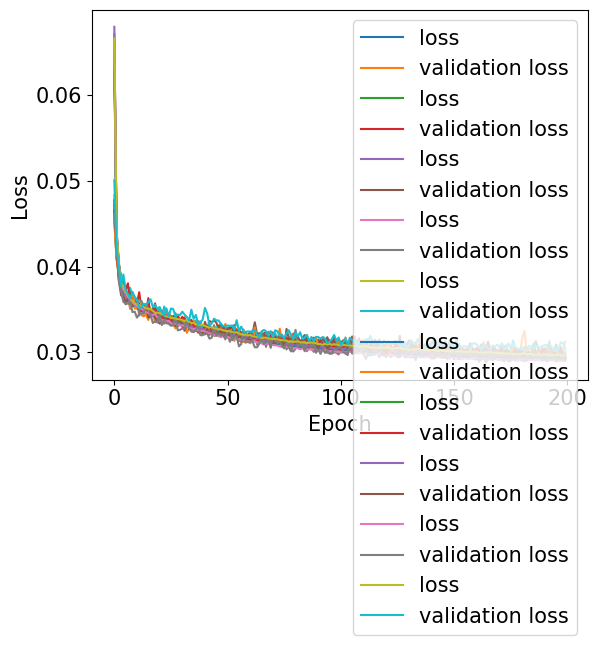

In [21]:
n_epochs = 200
X = Steps.iloc[:,100:]
y = Steps.iloc[:,0:100]
# split data for training & testing
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

NNdata = {}
for k, (TrainInds, TestInds) in enumerate(skf.split(Steps.iloc[:, 100:], Meta['Subj'])):
  NNdata[str(k)] = {}
  print('Iteration: ' + str(k))

  # specify testing & training sets
  X_train = Steps.iloc[TrainInds, 100:].to_numpy()
  y_train = Steps.iloc[TrainInds,:100].to_numpy()
  X_test = Steps.iloc[TestInds, 100:].to_numpy()
  y_test = Steps.iloc[TestInds,:100].to_numpy()
  Meta_train = Meta.iloc[TrainInds]
  Meta_test = Meta.iloc[TestInds]
  # TrainInds = [i for i, x in enumerate(Meta['Subj']) if x in S[TrainSubj]]
  # TestInds = [i for i, x in enumerate(Meta['Subj']) if x in S[TestSubj]]
  # X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=Meta['Load'],
  #                                                     random_state=42)

  model = createModel()
  lr_callback = tf.keras.callbacks.LearningRateScheduler(learningRateScheduler)
  history = model.fit(X_train, y_train, epochs=n_epochs, #callbacks=[lr_callback],
                      validation_data=(X_test, y_test), verbose=0)


  # save data and model in dict
  NNdata[str(k)]['TrainInds'] = TrainInds
  NNdata[str(k)]['TestInds'] = TestInds
  NNdata[str(k)]['True'] = y_test
  NNdata[str(k)]['Pred'] = model.predict(X_test)

  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label = 'validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc='upper right')
  plt.savefig('Figures/LossCurve_relu200' + str(k) + '.png')

  # save tf model
  tfmodel = 'Models/tfmodel_' + str(k)
  tf.saved_model.save(model, tfmodel)
  onnxFN = 'Models/tfmodel_' + str(k) + '.onnx'
  !python -m tf2onnx.convert --saved-model $tfmodel --output $onnxFN

In [24]:
import pickle
# save NN training and testing data
f = open('NNdata.pkl', 'wb')
pickle.dump(NNdata, f)
f.close()

# Plot Results

42/87 [=============>................] - ETA: 0s

<ipython-input-27-c0f5d5beba27>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  C = cm.get_cmap('viridis', 5)


87/87 [==============================] - 0s 2ms/step


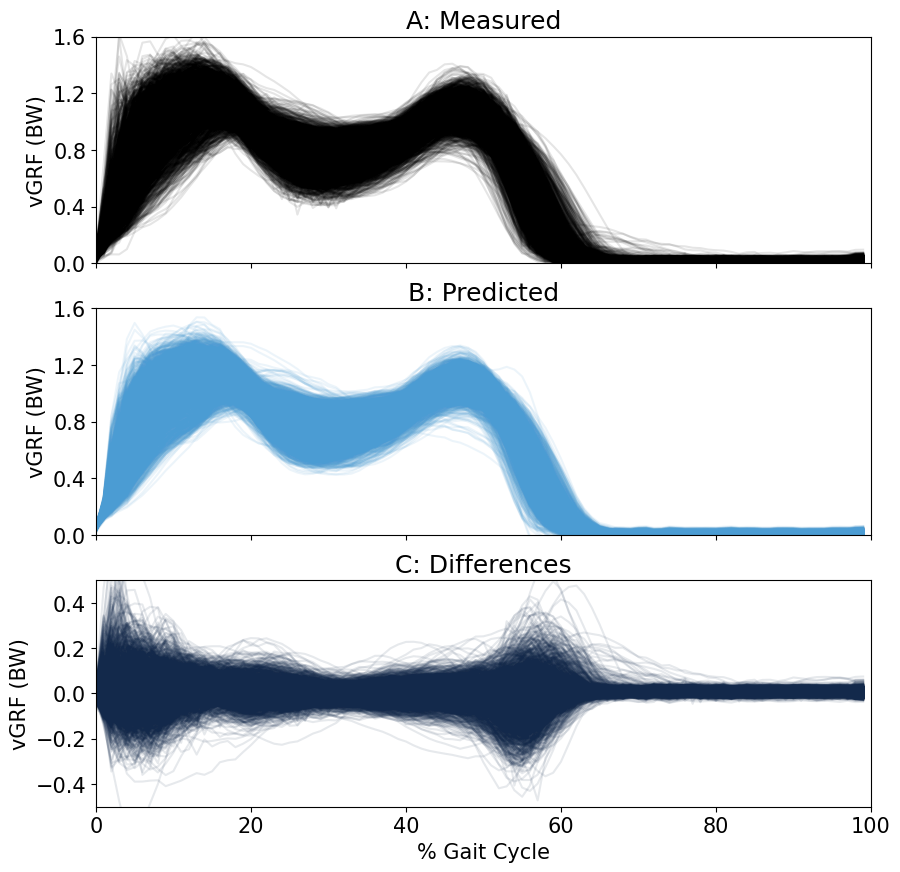

In [27]:
# plot all raw predicitons
A = 0.1
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
C = cm.get_cmap('viridis', 5)

plt.figure(figsize=(10, 10))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

y_pred = model.predict(X_test) # make predictions with model

for i, x in enumerate(range(len(y_test))):
  ax1.plot(y_test[i,:], '-k', alpha=A)
  ax2.plot(y_pred[i,:], '-', alpha=A, c=(75/255, 156/255, 211/255))
  ax3.plot(y_test[i,:] - y_pred[i,:], '-', alpha=A, c=(19/255, 41/255, 75/255))

ax1.set_title('A: Measured')
ax1.set_ylabel('vGRF (BW)')
ax1.set_ylim((0, 1.6))
ax1.set_yticks([0, 0.4, 0.8, 1.2, 1.6])
ax1.set_xlim((0, 100))
ax1.set_xticks([0, 20, 40, 60, 80, 100], labels = [])

ax2.set_title('B: Predicted')
ax2.set_ylabel('vGRF (BW)')
ax2.set_ylabel('vGRF (BW)')
ax2.set_ylim((0, 1.6))
ax2.set_yticks([0, 0.4, 0.8, 1.2, 1.6])
ax2.set_xlim((0, 100))
ax2.set_xticks([0, 20, 40, 60, 80, 100], labels = [])

ax3.set_title('C: Differences')
ax3.set_ylabel('vGRF (BW)')
ax3.set_xlabel('% Gait Cycle')
ax3.set_ylabel('vGRF (BW)')
ax3.set_ylim((-0.5, 0.5))
ax3.set_xlim((0, 100))
ax3.set_xticks([0, 20, 40, 60, 80, 100])

plt.savefig('Figures/MeasuredAndPredictions.png')

In [ ]:
# # create dataframe of subject average waveforms
# model = 'W'
# colnames = []
# for x in range(99):
#   colnames.append('grf'+str(x))
# C = ['Subj','Cond'] + colnames
# Conds = ['control', 'over', 'under']
# SubMLP = {}
# SubAvgsP = pd.DataFrame(columns=C)
# SubAvgsT = pd.DataFrame(columns=C)
# SubAvgsMAE = pd.DataFrame(columns=C)
# SubPkP = pd.DataFrame(columns=['Subj','Cond', 'Sys','vGRF'])
# SubPkT = pd.DataFrame(columns=['Subj','Cond', 'Sys', 'vGRF'])
# SubPkMAE = pd.DataFrame(columns=['Subj','Cond', 'vGRF'])
# j = 0
# for i in range(len(AggMLP[model])):
#   M = AggMLP[model][i]['Test Metadata']

#   for S in np.unique(M['Subj']):
#     SubMLP[S] = {}
#     for C in Conds:
#       SubMLP[S][C] = {}
#       SubjInds = [x for x, z in enumerate(M['Subj'].tolist()) if z == S]
#       CondInds = [x for x, z in enumerate(M['Cond'].tolist()) if z == C]
#       match = list(set(SubjInds) & set(CondInds))
#       match.sort()

#       # save full waveform
#       SubMLP[S][C]['Pred'] = np.mean(AggMLP[model][i]['Prediction'][match, :], axis=0)
#       SubMLP[S][C]['True'] = np.mean(AggMLP[model][i]['True'][match, :], axis=0)
#       SubMLP[S][C]['StanceErr'] = abs(SubMLP[S][C]['Pred'] - SubMLP[S][C]['True'])

#       SubAvgsP.loc[j] = np.hstack([S, C, SubMLP[S][C]['Pred']])
#       SubAvgsT.loc[j] = np.hstack([S, C, SubMLP[S][C]['True']])
#       SubAvgsMAE.loc[j] = np.hstack([S, C, SubMLP[S][C]['StanceErr']])

#       # save loading peak & error
#       SubMLP[S][C]['PredPk'] = np.mean(AggMLP[model][i]['PredPk'][match, :], axis=0)
#       SubMLP[S][C]['TruePk'] = np.mean(AggMLP[model][i]['TruePk'][match, :], axis=0)
#       SubMLP[S][C]['PkErr'] = np.mean(AggMLP[model][i]['PkErr'][match, :], axis=0)

#       SubPkP.loc[j] = [S, C, 'Pred', SubMLP[S][C]['PredPk'][0]]
#       SubPkT.loc[j] = [S, C, 'True', SubMLP[S][C]['TruePk'][0]]
#       SubPkMAE.loc[j] = [S, C, SubMLP[S][C]['PkErr'][0]]

#       j += 1

# SubPks = pd.concat([SubPkP, SubPkT], axis=0)

# Run Statistics

In [88]:
# create dataframe of all waveforms and loading peaks across all kfolds
colnames = []
for x in range(100):
  colnames.append('VGRF'+str(x))

# load NN data
f = open('NNdata.pkl', 'rb')
NNdata = pickle.load(f)
# Empty = np.zeros((len(NNdata[str(i)]['Pred']), 103))
# AllP = pd.DataFrame(data=Empty, columns=['Subj','Cond','Sys'] + colnames)
# AllT = pd.DataFrame(data=Empty, columns=['Subj','Cond','Sys'] + colnames)
# AllMAE = pd.DataFrame(data=Empty[:,:-1], columns=['Subj','Cond'] + colnames)
# AllGCMAE = pd.DataFrame(data=Empty[:,:4], columns=['Subj','Cond', 'Sys', 'vGRF'])
# AllPkP = pd.DataFrame(data=Empty[:,:4], columns=['Subj','Cond', 'Sys', 'vGRF'])
# AllPkT = pd.DataFrame(data=Empty[:,:4], columns=['Subj','Cond', 'Sys', 'vGRF'])
# AllPkMAE = pd.DataFrame(data=Empty[:,:3], columns=['Subj','Cond', 'vGRF'])
AllP = pd.DataFrame(columns=['Subj','Cond','Sys'] + colnames)
AllT = pd.DataFrame(columns=['Subj','Cond','Sys'] + colnames)
AllMAE = pd.DataFrame(columns=['Subj','Cond'] + colnames)
AllGCMAE = pd.DataFrame(columns=['Subj','Cond', 'vGRF'])
AllPkP = pd.DataFrame(columns=['Subj','Cond', 'Sys', 'vGRF'])
AllPkT = pd.DataFrame(columns=['Subj','Cond', 'Sys', 'vGRF'])
AllPkMAE = pd.DataFrame(columns=['Subj','Cond', 'vGRF'])

j = 0
for i in range(10):
  pred = NNdata[str(i)]['Pred']
  true = NNdata[str(i)]['True']
  S = Meta['Subj'].iloc[NNdata[str(i)]['TestInds'].tolist()].to_list()
  C = Meta['Load'].iloc[NNdata[str(i)]['TestInds'].tolist()].to_list()
  N = len(NNdata[str(i)]['Pred'])

  # save predicted full waveform
  Mdf = pd.DataFrame([S, C, np.repeat('Pred', N)]).T
  Mdf.columns = ['Subj','Cond','Sys']
  Vdf = pd.DataFrame(pred, columns=colnames)
  DF = pd.concat([Mdf, Vdf], axis=1)
  AllP = pd.concat([AllP, DF], axis=0)
  # save true full waveform
  Mdf = pd.DataFrame([S, C, np.repeat('Pred', N)]).T
  Mdf.columns = ['Subj','Cond','Sys']
  Vdf = pd.DataFrame(true, columns=colnames)
  DF = pd.concat([Mdf, Vdf], axis=1)
  AllT = pd.concat([AllT, DF], axis=0)
  # save MAE full waveform
  Mdf = pd.DataFrame([S, C]).T
  Mdf.columns = ['Subj','Cond']
  Vdf = pd.DataFrame(abs(true - pred), columns=colnames)
  DF = pd.concat([Mdf, Vdf], axis=1)
  AllMAE = pd.concat([AllMAE, DF], axis=0)
  # save average MAE
  Mdf = pd.DataFrame([S, C]).T
  Mdf.columns = ['Subj','Cond']
  Vdf = pd.DataFrame(np.mean(abs(true - pred), axis=1), columns=['vGRF'])
  DF = pd.concat([Mdf, Vdf], axis=1)
  AllGCMAE = pd.concat([AllGCMAE, DF], axis=0)

  # save predicted loading peak & error
  Mdf = pd.DataFrame([S, C, np.repeat('Pred', N)]).T
  Mdf.columns = ['Subj','Cond','Sys']
  Vdf = pd.DataFrame(np.max(pred[:, 10:30], axis=1), columns=['vGRF'])
  DF = pd.concat([Mdf, Vdf], axis=1)
  AllPkP = pd.concat([AllPkP, DF], axis=0)
  # save true loading peak & error
  Mdf = pd.DataFrame([S, C, np.repeat('True', N)]).T
  Mdf.columns = ['Subj','Cond','Sys']
  Vdf = pd.DataFrame(np.max(true[:, 10:30], axis=1), columns=['vGRF'])
  DF = pd.concat([Mdf, Vdf], axis=1)
  AllPkT = pd.concat([AllPkT, DF], axis=0)
  # save predicted loading peak & error
  Mdf = pd.DataFrame([S, C]).T
  Mdf.columns = ['Subj','Cond']
  Vdf = pd.DataFrame(abs(np.max(true[:, 10:30], axis=1) - np.max(pred[:, 10:30], axis=1)), columns=['vGRF'])
  DF = pd.concat([Mdf, Vdf], axis=1)
  AllPkMAE = pd.concat([AllPkMAE, DF], axis=0)

  j += 1

AllPks = pd.concat([AllPkP, AllPkT], axis=0)
AllPks.reset_index(inplace=True, drop=True)
# SubMAEs = pd.concat([SubPkP, SubPkT], axis=0)

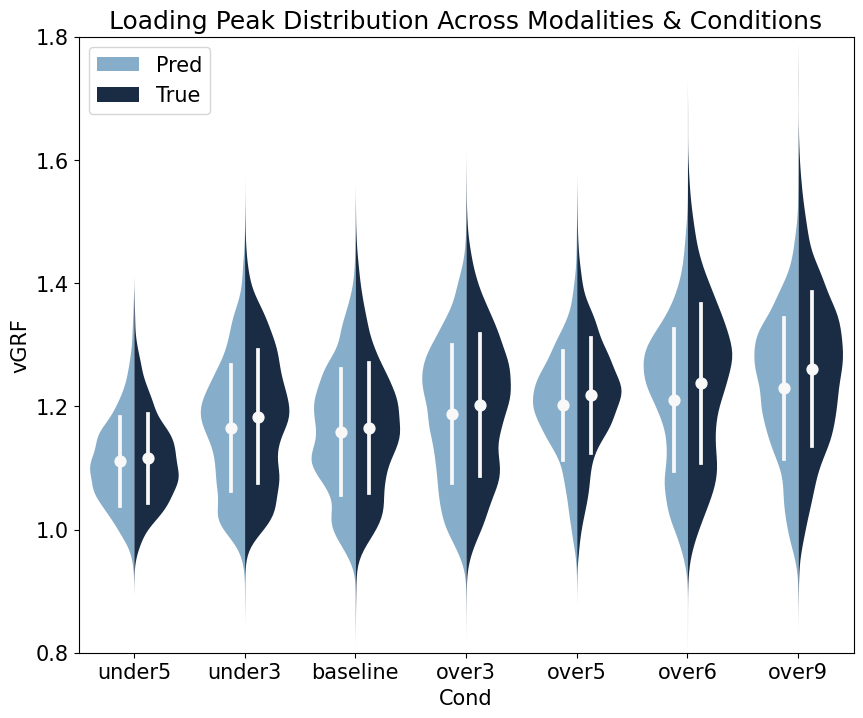

In [125]:
Ord = ['under5', 'under3', 'baseline', 'over3', 'over5', 'over6', 'over9']
plt.figure(figsize = (10, 8))
sb.violinplot(data=AllPks, x='Cond', y='vGRF', hue='Sys',
              split=True, order=Ord, linewidth=0, scale='count',
                   palette={'Pred': '#7BAFD4', 'True': '#13294B'})

# sb.boxplot(data=AllPks, x='Cond', y='vGRF', hue='Sys',
#            order=Ord, width=0.4, showfliers=False, color='w',
#            showcaps=False, #palette={'Pred': 'k', 'True': 'k'},
#            boxprops={'facecolor':'#F8F8F8', 'linewidth': 1, 'edgecolor': '#F8F8F8'})

ax2 = sb.pointplot(data=AllPks, x='Cond', y='vGRF', hue='Sys',
           order=Ord, dodge=0.25, join=False,  palette=['#F8F8F8'],
                   errorbar='sd')

plt.setp(ax2.lines, zorder=100)
plt.setp(ax2.collections, zorder=100, label='')
ax2.set_xticklabelrotation = 60
ax2.set_ylim([0.8, 1.8])
ax2.legend(loc='upper left')
ax2.set_title('Loading Peak Distribution Across Modalities & Conditions')

plt.savefig('Figures/PeakViolinPlot.png')

In [25]:
# create dataframe of subject averaged waveforms and loading peaks
# colnames = []
# for x in range(100):
#   colnames.append('VGRF'+str(x))

# # load NN data
# f = open('NNdata.pkl', 'rb')
# NNdata = pickle.load(f)

SubAvgsP = pd.DataFrame(columns=['Subj','Cond','Sys'] + colnames)
SubAvgsT = pd.DataFrame(columns=['Subj','Cond','Sys'] + colnames)
SubAvgsMAE = pd.DataFrame(columns=['Subj','Cond'] + colnames)
SubGCMAE = pd.DataFrame(columns=['Subj','Cond', 'Sys', 'vGRF'])
SubPkP = pd.DataFrame(columns=['Subj','Cond', 'Sys', 'vGRF'])
SubPkT = pd.DataFrame(columns=['Subj','Cond', 'Sys', 'vGRF'])
SubPkMAE = pd.DataFrame(columns=['Subj','Cond', 'vGRF'])

# Meta_test = Meta.iloc[y_test.index,:]

j = 0
for S in np.unique(Meta_test['Subj']):
  for C in enumerate(np.unique(Meta_test[Meta_test['Subj'] == S]['Load'])): #np.unique(Meta_test['Load']):

    # get indicies of subject and loading condition
    SubjInds = [x for x, z in enumerate(AllP['Subj'].tolist()) if z == S]
    CondInds = [x for x, z in enumerate(AllP['Load'].tolist()) if z == C]
    match = list(set(SubjInds) & set(CondInds))
    match.sort()

    # save full waveform
    SubAvgsP.loc[j] = np.hstack([S, C, 'Pred', np.mean(pred[k, :], axis=0)])
    SubAvgsT.loc[j] = np.hstack([S, C, 'True', np.mean(true[k, :], axis=0)])
    SubAvgsMAE.loc[j] = np.hstack([S, C, abs(np.mean(true[k, :] - pred[k, :], axis=0))])

    # save loading peak & error
    SubPkP.loc[j] = [S, C, 'Pred', np.mean(np.max(pred[k, 10:30], axis=1), axis=0)]
    SubPkT.loc[j] = [S, C, 'True', np.mean(np.max(true[k, 10:30], axis=1), axis=0)]
    SubPkMAE.loc[j] = [S, C, np.mean(abs(np.max(true[k, 10:30], axis=1) - np.max(pred[k, 10:30], axis=1)), axis=0)]

    j += 1

SubPks = pd.concat([SubPkP, SubPkT], axis=0)
# SubMAEs = pd.concat([SubPkP, SubPkT], axis=0)

Series([], Name: Cond, dtype: object)

In [ ]:
np.max(y_pred[match, 10:30], axis=1)

### MAE Stats

In [ ]:
# GC MAE ANOVA
pg.rm_anova(SubGCMAE, dv='vGRF', within=['Cond'], subject='Subj', effsize = 'np2').round(3)

In [ ]:
# GC MAE Tukeys
pg.pairwise_tukey(SubGCMAE, dv='vGRF', between='Cond', effsize='eta-square')

In [160]:
# Loading Peak MAE ANOVA
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(SubPkMAE['Cond'])

SubPkMAE['CondLE'] = le.transform(SubPkMAE['Cond'])
pg.rm_anova(SubPkMAE, dv='vGRF', within='CondLE', subject='Subj', effsize = 'np2') #.round(3)

/usr/local/lib/python3.10/dist-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,np2,eps
0,CondLE,4,48,0.254655,0.905411,0.02078,0.708756


In [161]:
# Loading Peak MAE Tukeys
pg.pairwise_tukey(SubPkMAE, dv='vGRF', between='CondLE', effsize='eta-square')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,eta-square
0,0,1,0.034232,0.036340,-0.002109,0.002915,-0.723342,0.950749,0.008251
1,0,2,0.034232,0.036635,-0.002403,0.002915,-0.824438,0.922628,0.008894
2,0,3,0.034232,0.036933,-0.002701,0.003828,-0.705590,0.954884,0.011109
3,0,4,0.034232,0.036856,-0.002625,0.003932,-0.667560,0.962968,0.009668
4,1,2,0.036340,0.036635,-0.000295,0.002936,-0.100372,0.999977,0.000173
5,1,3,0.036340,0.036933,-0.000593,0.003844,-0.154143,0.999872,0.000785
6,1,4,0.036340,0.036856,-0.000516,0.003948,-0.130775,0.999933,0.000533
7,2,3,0.036635,0.036933,-0.000298,0.003844,-0.077483,0.999992,0.000146
8,2,4,0.036635,0.036856,-0.000222,0.003948,-0.056121,0.999998,0.000074
9,3,4,0.036933,0.036856,0.000076,0.004663,0.016368,1.000000,0.000008


### Loading Peak ANOVA

In [162]:
# Loading Peak ANOVA
pg.rm_anova(SubPks, dv='vGRF', within=['Sys','Cond'], subject='Subj', effsize = 'np2').round(3)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Sys,0.006,1,12,0.006,6.097,0.030,0.030,0.337,1.000
1,Cond,0.012,4,48,0.003,1.851,0.135,0.162,0.134,0.673
2,Sys * Cond,0.000,4,48,0.000,0.527,0.716,0.606,0.042,0.528


In [163]:
# Tukey's post hoc between Pred conds
pg.rm_anova(SubPks.loc[SubPks['Sys']=='Pred'], dv='vGRF', within=['Cond'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Sys']=='Pred'], dv='vGRF', between='Cond', effsize='eta-square')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,eta-square
0,0,1,1.187113,1.211492,-0.024378,0.014388,-1.694389,0.441147,0.045198
1,0,2,1.187113,1.189275,-0.002161,0.014388,-0.150219,0.999884,0.000300
2,0,3,1.187113,1.206961,-0.019847,0.018895,-1.050430,0.831214,0.025318
3,0,4,1.187113,1.192375,-0.005262,0.019407,-0.271125,0.998799,0.002049
4,1,2,1.211492,1.189275,0.022217,0.014492,1.533100,0.543080,0.033846
5,1,3,1.211492,1.206961,0.004531,0.018974,0.238790,0.999272,0.001576
6,1,4,1.211492,1.192375,0.019117,0.019484,0.981147,0.863310,0.031499
7,2,3,1.189275,1.206961,-0.017686,0.018974,-0.932134,0.883898,0.017634
8,2,4,1.189275,1.192375,-0.003100,0.019484,-0.159124,0.999854,0.000610
9,3,4,1.206961,1.192375,0.014586,0.023014,0.633791,0.969291,0.013902


In [164]:
# Tukey's post hoc between Meas conds
pg.rm_anova(SubPks.loc[SubPks['Sys']=='True'], dv='vGRF', within=['Cond'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Sys']=='True'], dv='vGRF', between='Cond', effsize='eta-square')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,eta-square
0,0,1,1.196196,1.222373,-0.026177,0.014860,-1.761618,0.400618,0.047012
1,0,2,1.196196,1.193679,0.002517,0.014860,0.169394,0.999813,0.000388
2,0,3,1.196196,1.220452,-0.024256,0.019515,-1.242948,0.726249,0.035024
3,0,4,1.196196,1.207782,-0.011586,0.020043,-0.578019,0.978075,0.009175
4,1,2,1.222373,1.193679,0.028694,0.014967,1.917169,0.313697,0.051959
5,1,3,1.222373,1.220452,0.001922,0.019596,0.098055,0.999979,0.000257
6,1,4,1.222373,1.207782,0.014592,0.020123,0.725113,0.950324,0.016666
7,2,3,1.193679,1.220452,-0.026773,0.019596,-1.366208,0.650323,0.038533
8,2,4,1.193679,1.207782,-0.014103,0.020123,-0.700817,0.955956,0.012150
9,3,4,1.220452,1.207782,0.012670,0.023769,0.533057,0.983765,0.010020


In [ ]:
# Tukey's post hoc between Meas & Pred - Control Condition
pg.rm_anova(SubPks.loc[SubPks['Cond']=='control'], dv='vGRF', within=['Sys'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Cond']=='control'], dv='vGRF', between='Sys', effsize='eta-square')

In [ ]:
# Tukey's post hoc between Meas & PredP - Over Condition
pg.rm_anova(SubPks.loc[SubPks['Cond']=='over'], dv='vGRF', within=['Sys'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Cond']=='over'], dv='vGRF', between='Sys', effsize='eta-square')

In [ ]:
# Tukey's post hoc between Meas & Pred - Under Condition
pg.rm_anova(SubPks.loc[SubPks['Cond']=='under'], dv='vGRF', within=['Sys'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Cond']=='under'], dv='vGRF', between='Sys', effsize='eta-square')

### Plot Results

In [ ]:
# Plot Results figures
fnt = 16
plt.rcParams.update({'font.size': fnt})
fig = plt.figure(figsize=(20,6))

# plot full vGRF waveform
ax1 = plt.subplot(141)
ax1.plot(np.mean(np.array(SubAvgsT[SubAvgsT['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=0), '-b')
ax1.plot(np.mean(np.array(SubAvgsP[SubAvgsP['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=0), '--b')
ax1.plot(np.mean(np.array(SubAvgsT[SubAvgsT['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=0), '-r')
ax1.plot(np.mean(np.array(SubAvgsP[SubAvgsP['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=0), '--r')
ax1.plot(np.mean(np.array(SubAvgsT[SubAvgsT['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=0), '-k', label='Meas')
ax1.plot(np.mean(np.array(SubAvgsP[SubAvgsP['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=0), '--k', label='Est')
ax1.set_title('A: Full vGRF')
ax1.legend(loc='upper right')
ax1.set_ylim([0, 1.25])
ax1.set_xlim([0, 100])
ax1.set_xlabel('% Gait Cycle')
ax1.set_ylabel('BW')
ax1.text(28, 0.22, 'Over-Loading', c='r', ha='center', fontsize=12)
ax1.text(28, 0.15, 'Control', c='k', ha='center', fontsize=12)
ax1.text(28, 0.08, 'Under-Loading', c='b', ha='center', fontsize=12)
ax1.vlines(15, 0.65, 1)
ax1.text(10, 0.60, 'Loading Peak', fontsize=12)
ax1.text(-30, 0.60, 'Waist Model', fontsize=25, ha='center', va='center', rotation='vertical')


# plot predicted & true peaks
ax2 = plt.subplot(143)
ht = 0.5
p = 0

# under
ax2.boxplot(SubPkT[SubPkT['Cond'] == 'under'].vGRF,
            positions=[0.8],
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "white", "linewidth": 2},
            boxprops={"facecolor": 'b', "edgecolor": 'b',
                        "linewidth": 2},
            whiskerprops={"color": "b", "linewidth": 2},
            capprops={"color": "b", "linewidth": 2})

ax2.boxplot(SubPkP[SubPkP['Cond'] == 'under'].vGRF,
            positions=[1.2],
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "b", "linewidth": 2},
            boxprops={"facecolor": 'w', "edgecolor": 'b',
                        "linewidth": 2},
            whiskerprops={"color": "b", "linewidth": 2},
            capprops={"color": "b", "linewidth": 2})

# control
ax2.boxplot(SubPkT[SubPkT['Cond'] == 'control'].vGRF,
            positions=[1.8],
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "white", "linewidth": 2},
            boxprops={"facecolor": 'k', "edgecolor": 'k',
                        "linewidth": 2},
            whiskerprops={"color": "k", "linewidth": 2},
            capprops={"color": "k", "linewidth": 2})

ax2.boxplot(SubPkP[SubPkP['Cond'] == 'control'].vGRF,
            positions=[2.2],
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "k", "linewidth": 2},
            boxprops={"facecolor": 'w', "edgecolor": 'k',
                        "linewidth": 2},
            whiskerprops={"color": "k", "linewidth": 2},
            capprops={"color": "k", "linewidth": 2})

# over
ax2.boxplot(SubPkT[SubPkT['Cond'] == 'over'].vGRF,
            positions=[2.8],
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "white", "linewidth": 2},
            boxprops={"facecolor": 'r', "edgecolor": 'r',
                        "linewidth": 2},
            whiskerprops={"color": "r", "linewidth": 2},
            capprops={"color": "r", "linewidth": 2})
ax2.boxplot(SubPkP[SubPkP['Cond'] == 'over'].vGRF,
            positions=[3.2],
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "r", "linewidth": 2},
            boxprops={"facecolor": 'white', "edgecolor": 'r',
                        "linewidth": 2},
            whiskerprops={"color": "r", "linewidth": 2},
            capprops={"color": "r", "linewidth": 2})

ax2.set_xticks(ticks=[1, 2, 3])
ax2.set_xticklabels(['Under', 'Control', 'Over'])
ax2.set_title('C: Loading Peaks')
ax2.set_xlim([0.6, 3.4])
ax2.set_ylim([1, 1.4])
ax2.text(3.2, 1.35, '*', color='r', fontsize=25, ha='center') # add statistical differences
ax2.text(2.8,1.35, '*', color='r', fontsize=25, ha='center')
ax2.plot(0.9, 1.38, 'sk', mfc='k', ms=16, mew=2)
ax2.text(1.05, 1.38, 'Measured', va='center')
ax2.plot(0.9, 1.34, 'sk', mfc='w', ms=16, mew=2)
ax2.text(1.05, 1.34, 'Estimated', va='center')


# Plot Stance Average Error
ax=plt.subplot(142)
for k in range(len(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'])):
  ax.plot([1,2,3], [np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1),
                    np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1),
                    np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1)],
          alpha=0.5, color=[0.8, 0.8, 0.8])

ax.errorbar([1], [np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))],
            yerr=[np.std(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))],
            color='b', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)
ax.errorbar([2], [np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))],
            yerr=[np.std(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))],
            color='k', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)
ax.errorbar([3], [np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))],
            yerr=[np.std(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))],
            color='r', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)

ax.set_xticks([1,2,3])
ax.set_xticklabels(['Under', 'Control', 'Over'])
ax.set_xlim([0.8, 3.2])
ax.set_ylim([0, 0.2])
ax.set_yticks([0,0.05,0.10, 0.15, 0.2])
ax.set_title('B: Gait Cycle MAE')

# plot peak average error
ax4=plt.subplot(144)
for k in range(len(SubPkT[SubPkT['Cond'] == 'control'])):
  ax4.plot([1,2,3], [SubPkMAE[SubPkMAE['Cond'] == 'under'].vGRF,
                    SubPkMAE[SubPkMAE['Cond'] == 'control'].vGRF,
                    SubPkMAE[SubPkMAE['Cond'] == 'over'].vGRF],
          alpha=0.5, color=[0.8, 0.8, 0.8])

ax4.errorbar([1], [np.mean(SubPkMAE[SubPkMAE['Cond'] == 'under'].vGRF)],
            yerr=[np.std(SubPkMAE[SubPkMAE['Cond'] == 'under'].vGRF)],
            color='b', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)
ax4.errorbar([2], [np.mean(SubPkMAE[SubPkMAE['Cond'] == 'control'].vGRF)],
            yerr=[np.std(SubPkMAE[SubPkMAE['Cond'] == 'control'].vGRF)],
            color='k', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)
ax4.errorbar([3], [np.mean(SubPkMAE[SubPkMAE['Cond'] == 'over'].vGRF)],
            yerr=[np.std(SubPkMAE[SubPkMAE['Cond'] == 'over'].vGRF)],
            color='r', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)

ax4.set_xticks([1,2,3])
ax4.set_xticklabels(['Under', 'Control', 'Over'])
ax4.set_xlim([0.8, 3.2])
ax4.set_ylim([0, 0.2])
ax4.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
ax4.set_title('D: Loading Peak MAE')

# plt.savefig('W_sensitivity.png')
# plt.savefig('W_sensitivity.pdf')

In [ ]:
# # output average errors by condition
# Ue = np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))
# Ce = np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))
# Oe = np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))
# print('GC Under MAE:', round(100*Ue, 2), ' %BW')
# print('GC Control MAE:', round(100*Ce, 2), ' %BW')
# print('GC Over MAE:', round(100*Oe, 2), ' %BW')

# Ue = np.mean(np.mean(np.array(SubAvgsRMSE[SubAvgsRMSE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))
# Ce = np.mean(np.mean(np.array(SubAvgsRMSE[SubAvgsRMSE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))
# Oe = np.mean(np.mean(np.array(SubAvgsRMSE[SubAvgsRMSE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))
# print('GC Under RMSE:', round(100*Ue, 2), ' %BW')
# print('GC Control RMSE:', round(100*Ce, 2), ' %BW')
# print('GC Over RMSE:', round(100*Oe, 2), ' %BW')
# print(' ')

# Ue = np.mean(np.mean(np.array(SubPkMAE[SubPkMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))
# Ce = np.mean(np.mean(np.array(SubPkMAE[SubPkMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))
# Oe = np.mean(np.mean(np.array(SubPkMAE[SubPkMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))
# print('Pk Under MAE:', round(100*Ue, 2), ' %BW')
# print('Pk Control MAE:', round(100*Ce, 2), ' %BW')
# print('Pk Over MAE:', round(100*Oe, 2), ' %BW')

# Ue = np.mean(np.mean(np.array(SubPkRMSE[SubPkRMSE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))
# Ce = np.mean(np.mean(np.array(SubPkRMSE[SubPkRMSE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))
# Oe = np.mean(np.mean(np.array(SubPkRMSE[SubPkRMSE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))
# print('Pk Under RMSE:', round(100*Ue, 2), ' %BW')
# print('Pk Control RMSE:', round(100*Ce, 2), ' %BW')
# print('Pk Over RMSE:', round(100*Oe, 2), ' %BW')


# Show model weight coefficients

In [ ]:
C = MLP['W']['Model'].coefs_
# sb.heatmap(C[0], cmap='icefire')
# MLP['W']['Model'].intercepts_

In [ ]:
Loss = MLP['W']['Model'].loss_curve_
plt.plot(Loss)
plt.title('Loss Curve')
plt.ylabel('BW')
plt.xlabel('Iteration')

plt.savefig('LossCurve.png')
plt.savefig('LossCurve.pdf')

In [ ]:
MatMulC = np.matmul(C[0], C[1])
# sb.heatmap(MatMulC, cmap='icefire')
# MatMulC[50:51, :] = np.zeros((99, 1)).T
r = 100
c = 99
df = pd.DataFrame({'W': np.repeat(range(1, c + 1), r),
                   'vGRF': np.tile(range(c), r),
                   'Wt': MatMulC.flatten()})

g = sb.jointplot(data=df, x='vGRF', y='W', kind='hist', bins=(r, c))
g.ax_marg_y.cla()
g.ax_marg_x.cla()
sb.heatmap(MatMulC, ax=g.ax_joint, cbar=False, cmap='icefire')

# y axis plots
g.ax_marg_y.barh(np.arange(0.5, r), np.mean(abs(MatMulC), axis=1) - np.mean(abs(MatMulC)), 1, color='k')
g.ax_marg_yy = g.ax_marg_y.twiny()
W_input = MLP['W']['Test Input'].mean(axis=0)
W_input[0] = W_input[1]
g.ax_marg_yy.plot(W_input, np.arange(r), 'k', alpha=0.3)

# x axis plots
g.ax_marg_x.bar(np.arange(0.5, c), np.mean(abs(MatMulC), axis=0) - np.mean(abs(MatMulC)), 1, color='k')
g.ax_marg_xx = g.ax_marg_x.twinx()
g.ax_marg_xx.plot(MLP['W']['Prediction'].mean(axis=0), 'k', alpha=0.3)

g.ax_joint.set_xticks([0, 20, 40, 60, 80, 99], labels=['0', '20', '40', '60', '80', '100'], fontsize=12)
g.ax_joint.set_yticks([0, 20, 40, 60, 80, 100], labels=['0', '20', '40', '60', '80', '100'], fontsize=12)
g.ax_joint.set_ylabel('W Acc (%GC)', rotation=-90)
g.ax_joint.yaxis.set_label_coords(-0.15 ,0.5)
g.ax_joint.set_xlabel('Estimated vGRF (%GC)')

g.ax_marg_y.set_xticks(())
g.ax_marg_x.set_yticks(())
g.ax_marg_yy.set_xticks(())
g.ax_marg_xx.set_yticks(())
g.ax_marg_y.axis('off')
g.ax_marg_yy.axis('off')
g.ax_marg_x.axis('off')
g.ax_marg_xx.axis('off')

plt.savefig('TrainingWeights.png')
plt.savefig('TrainingWeights.pdf')